In [34]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump, load

plt.style.use({"figure.facecolor": "white"})
from pyod.models.hbos import HBOS
from pyod.models.mcd import MCD
from pyod.models.lscp import LSCP
from pyod.models.pca import PCA
from pyod.models.hbos import HBOS
from pyod.models.lof import LOF
from pyod.models.iforest import IForest

# Импортируем данные

In [2]:
# !unzip dataset3.zip -d dataset3

## Эталонные данные

In [3]:
# считываем часть данных считающейся образцом без аномальных явлений
df = pd.read_csv(
    "dataset3/DB elder monitoring/data_ref_until_2020-02-13.csv",
    parse_dates=["timestamp"],
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75511 entries, 0 to 75510
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype                    
---  ------         --------------  -----                    
 0   timestamp      75511 non-null  datetime64[ns, UTC+01:00]
 1   temperature    75511 non-null  float64                  
 2   humidity       75511 non-null  float64                  
 3   CO2CosIRValue  75511 non-null  float64                  
 4   CO2MG811Value  75511 non-null  float64                  
 5   MOX1           75511 non-null  float64                  
 6   MOX2           75511 non-null  float64                  
 7   MOX3           75511 non-null  float64                  
 8   MOX4           75511 non-null  float64                  
 9   COValue        75511 non-null  float64                  
dtypes: datetime64[ns, UTC+01:00](1), float64(9)
memory usage: 5.8 MB


In [4]:
df.head()

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue
0,2020-01-25 00:01:49.251503+01:00,20.64,55.57,121.0,496.0,521.0,694.0,652.0,591.0,135.0
1,2020-01-25 00:02:09.350082+01:00,20.64,55.53,122.0,495.0,521.0,694.0,652.0,591.0,135.0
2,2020-01-25 00:02:29.319505+01:00,20.62,55.53,121.0,495.0,522.0,694.0,651.0,591.0,135.0
3,2020-01-25 00:02:49.399379+01:00,20.62,55.57,121.0,495.0,522.0,694.0,651.0,591.0,135.0
4,2020-01-25 00:03:09.158989+01:00,20.62,55.59,121.0,495.0,522.0,694.0,652.0,591.0,135.0


In [5]:
X = df.drop(columns=["timestamp"]).values
X

array([[ 20.64,  55.57, 121.  , ..., 652.  , 591.  , 135.  ],
       [ 20.64,  55.53, 122.  , ..., 652.  , 591.  , 135.  ],
       [ 20.62,  55.53, 121.  , ..., 651.  , 591.  , 135.  ],
       ...,
       [ 20.62,  57.75,  62.  , ..., 641.  , 591.  , 157.  ],
       [ 20.62,  57.74,  63.  , ..., 641.  , 591.  , 157.  ],
       [ 20.62,  57.74,  63.  , ..., 641.  , 591.  , 157.  ]])

## Неразмеченные данные

In [6]:
# считываем часть данных считающейся образцом без аномальных явлений
df_test = pd.read_csv('dataset3/DB elder monitoring/database_gas.csv', parse_dates=['timestamp'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416153 entries, 0 to 416152
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype                    
---  ------         --------------   -----                    
 0   timestamp      416153 non-null  datetime64[ns, UTC+01:00]
 1   temperature    416153 non-null  float64                  
 2   humidity       416153 non-null  float64                  
 3   CO2CosIRValue  416153 non-null  float64                  
 4   CO2MG811Value  416153 non-null  float64                  
 5   MOX1           416153 non-null  float64                  
 6   MOX2           416153 non-null  float64                  
 7   MOX3           416153 non-null  float64                  
 8   MOX4           416153 non-null  float64                  
 9   COValue        416153 non-null  float64                  
dtypes: datetime64[ns, UTC+01:00](1), float64(9)
memory usage: 31.8 MB


In [7]:
df_test.head()

,timestamp,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue
0,2019-11-06 11:37:13.038174+01:00,19.48,54.86,128.0,563.0,476.0,731.0,649.0,565.0,128.0
1,2019-11-06 11:37:32.744996+01:00,19.59,54.23,129.0,563.0,477.0,731.0,649.0,565.0,125.0
2,2019-11-06 11:37:53.018087+01:00,19.63,54.05,128.0,566.0,478.0,732.0,649.0,565.0,125.0
3,2019-11-06 11:38:13.093151+01:00,19.64,53.74,128.0,566.0,478.0,732.0,649.0,565.0,125.0
4,2019-11-06 11:38:33.032832+01:00,19.67,53.53,128.0,569.0,480.0,732.0,650.0,565.0,125.0


In [8]:
X_test = df_test.drop(columns=["timestamp"]).values
X_test

array([[ 19.48,  54.86, 128.  , ..., 649.  , 565.  , 128.  ],
       [ 19.59,  54.23, 129.  , ..., 649.  , 565.  , 125.  ],
       [ 19.63,  54.05, 128.  , ..., 649.  , 565.  , 125.  ],
       ...,
       [ 20.62,  57.75,  62.  , ..., 641.  , 591.  , 157.  ],
       [ 20.62,  57.74,  63.  , ..., 641.  , 591.  , 157.  ],
       [ 20.62,  57.74,  63.  , ..., 641.  , 591.  , 157.  ]])

### Визуализируем временные ряды

In [9]:
def show_plots(df, datetime_col, columns, anomaly_column=None):
    fig, axs = plt.subplots(
        len(columns), 1, sharex=True, constrained_layout=True, figsize=(12, 10)
    )
    for i in range(len(columns)):
        c = columns[i]

        axs[i].plot(df[datetime_col], df[c], color="gray", label="Normal")

        if anomaly_column:
            a = df.loc[df[anomaly_column] == 1, [datetime_col, c]]  # anomaly
            axs[i].scatter(a[datetime_col], a[c], color="red", label="Anomaly")

        axs[i].xaxis_date()
        axs[i].set_title(c)
        plt.xlabel("Date")
    plt.show()

In [10]:
columns = [
    "temperature",
    "humidity",
    "CO2CosIRValue",
    "CO2MG811Value",
    "MOX1",
    "MOX2",
    "MOX3",
    "COValue",
]

datetime_col = "timestamp"

## Эталонные данные

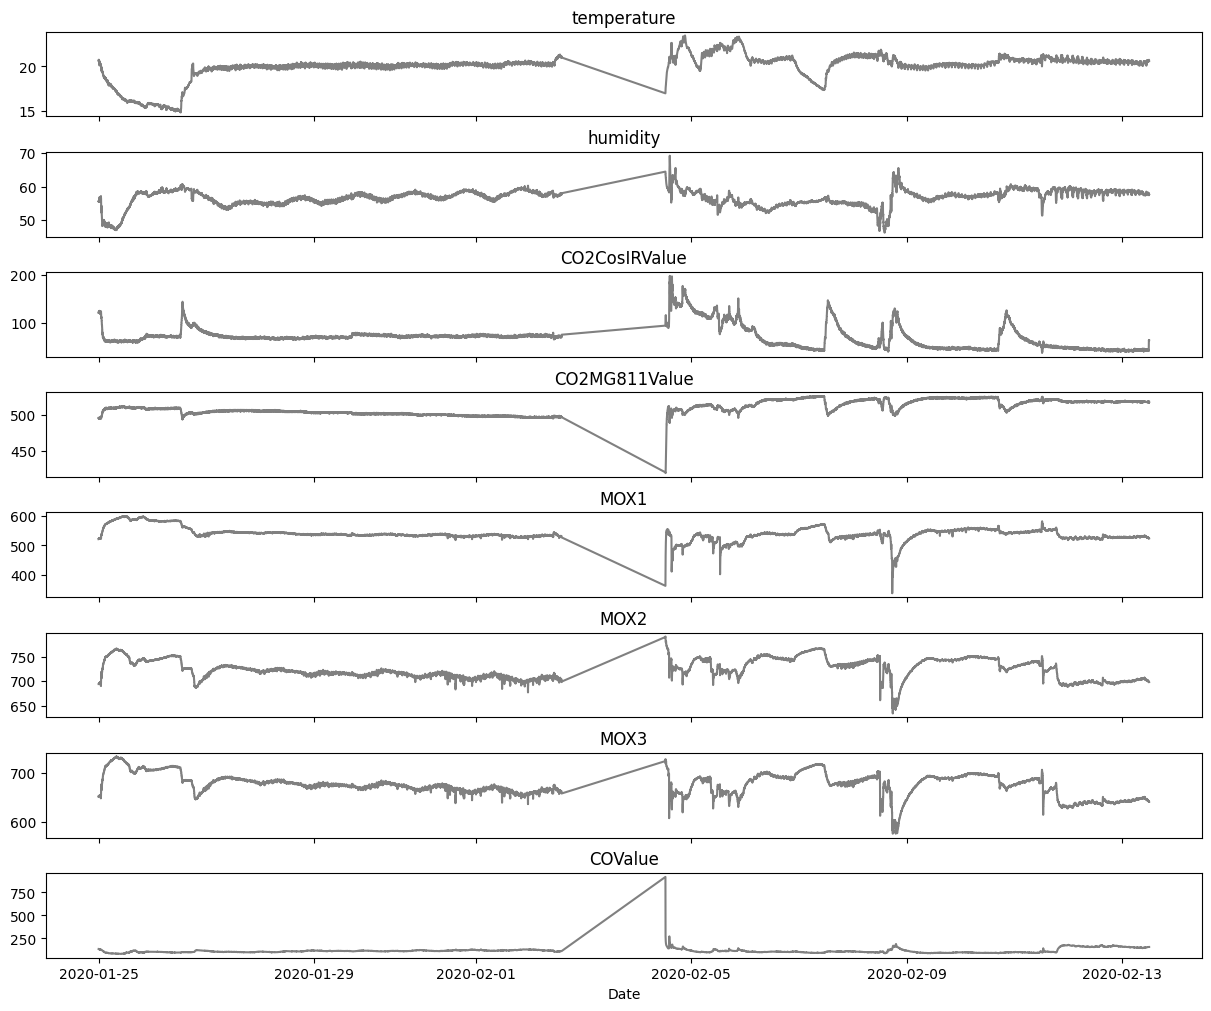

In [11]:
show_plots(df, datetime_col, columns)

## Неразмеченные данные

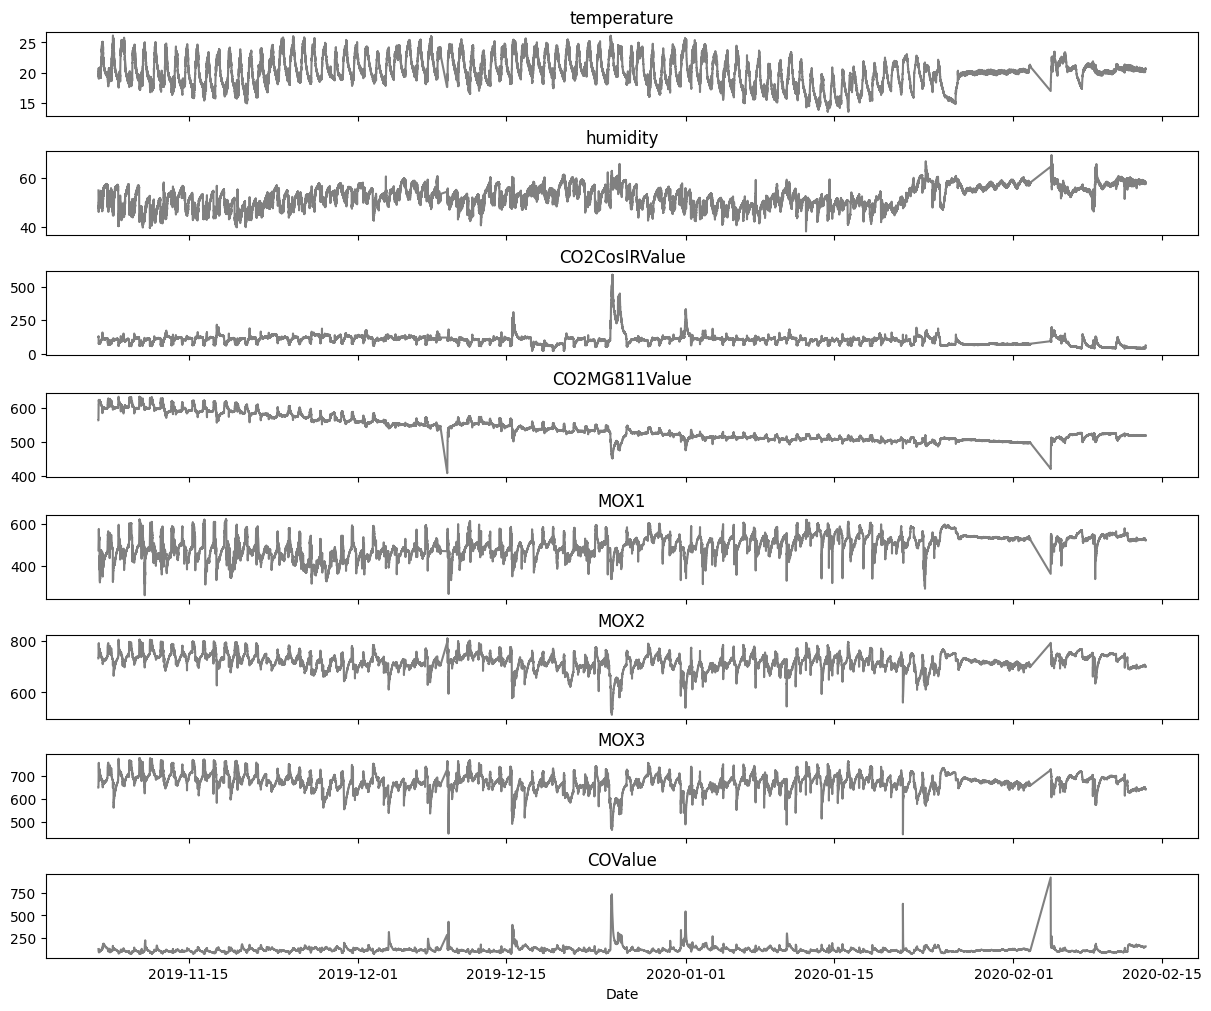

In [12]:
show_plots(df_test, datetime_col, columns)

# Используем простые модели детекции аномалий

## Histogram-based Outlier Detection (HBOS)

### Train

In [13]:
# поскольку это эталонные данные считаем, что аномалий в них нет
# однако с 0-ем алгоритмы не работают.
# Поэтому поставим маленькое значение с которым модель сможет работать.
outliers_fraction = 0.0001
random_state = np.random.RandomState(42)

model = HBOS(contamination=outliers_fraction)

In [14]:
model.fit(X)

HBOS(alpha=0.1, contamination=0.0001, n_bins=10, tol=0.5)

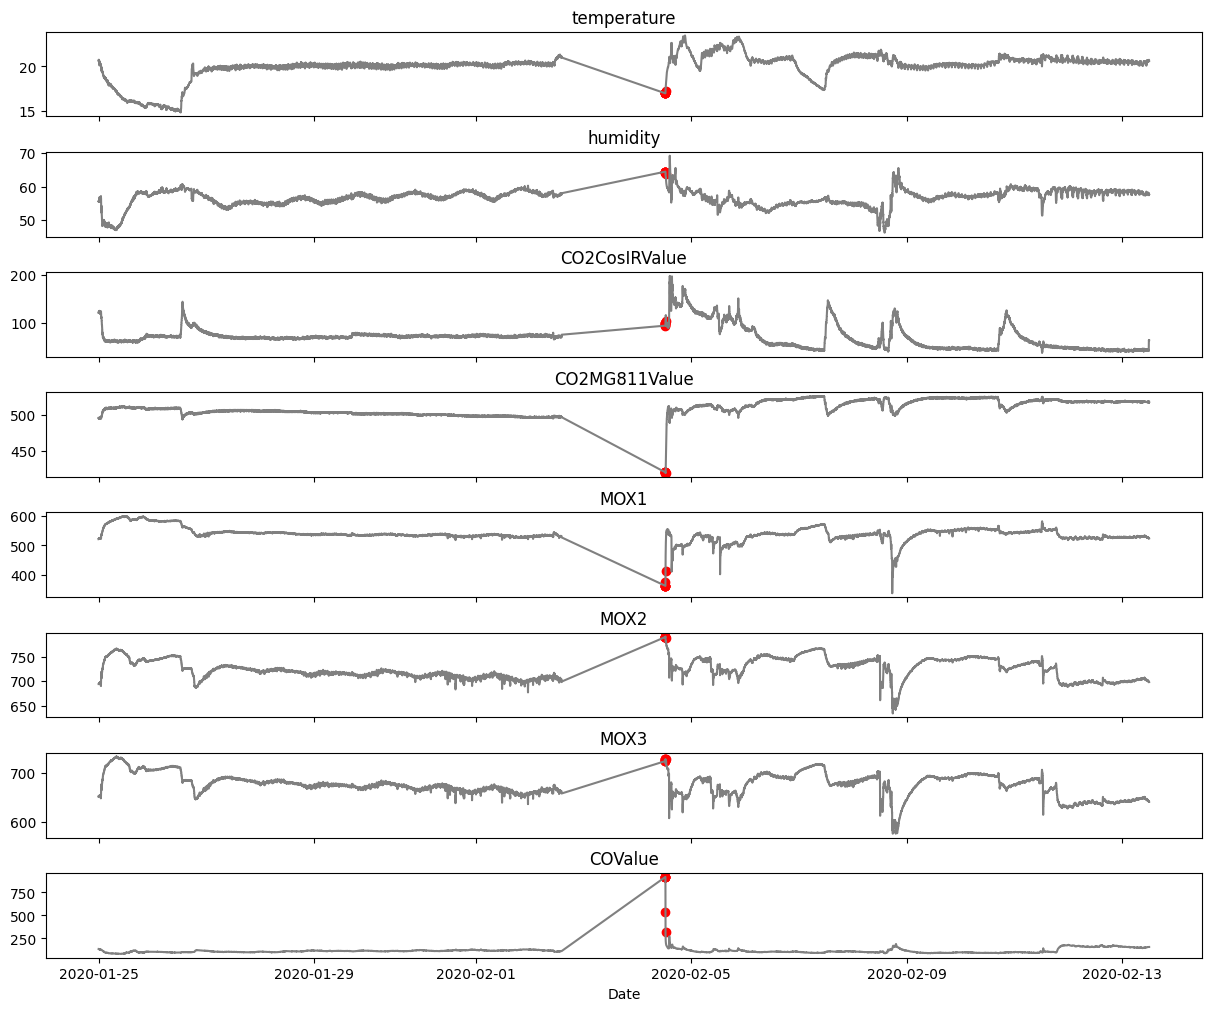

In [15]:
pred = model.predict(X)
df["anomaly"] = pred
show_plots(df, datetime_col, columns, 'anomaly')

### Predict

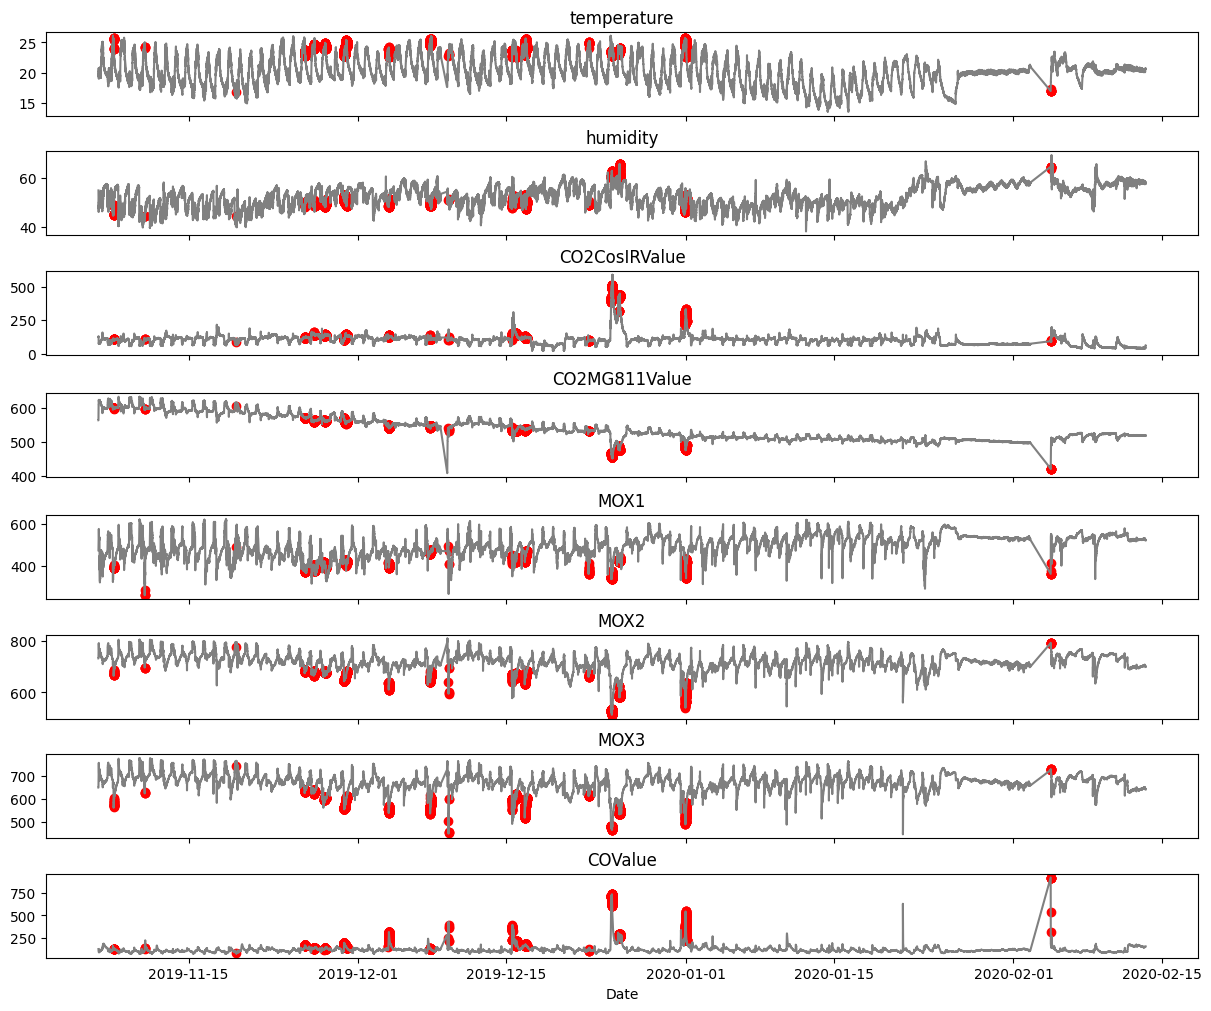

In [16]:
pred = model.predict(X_test)

df_test['anomaly'] = pred
show_plots(df_test, datetime_col, columns, 'anomaly')

### Сохраняем модель

Согласно офф. документации ([ссылка](https://pyod.readthedocs.io/en/latest/model_persistence.html))

In [17]:
# создадим папку для хранения сериализованных моделей
models_dir = "models"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [18]:
# save the model
model_filename = "HBOS_model.joblib"
model_path = os.path.join(models_dir, model_filename)
dump(model, model_path)

['models/HBOS_model.joblib']

In [19]:
# оценим размер сериализованной модели
model_size = os.path.getsize(model_path) / 1024**2
print(f"{model_size:.3} Мб")

1.15 Мб


### Загрузим модель

In [20]:
# load the model
model = load(model_path)

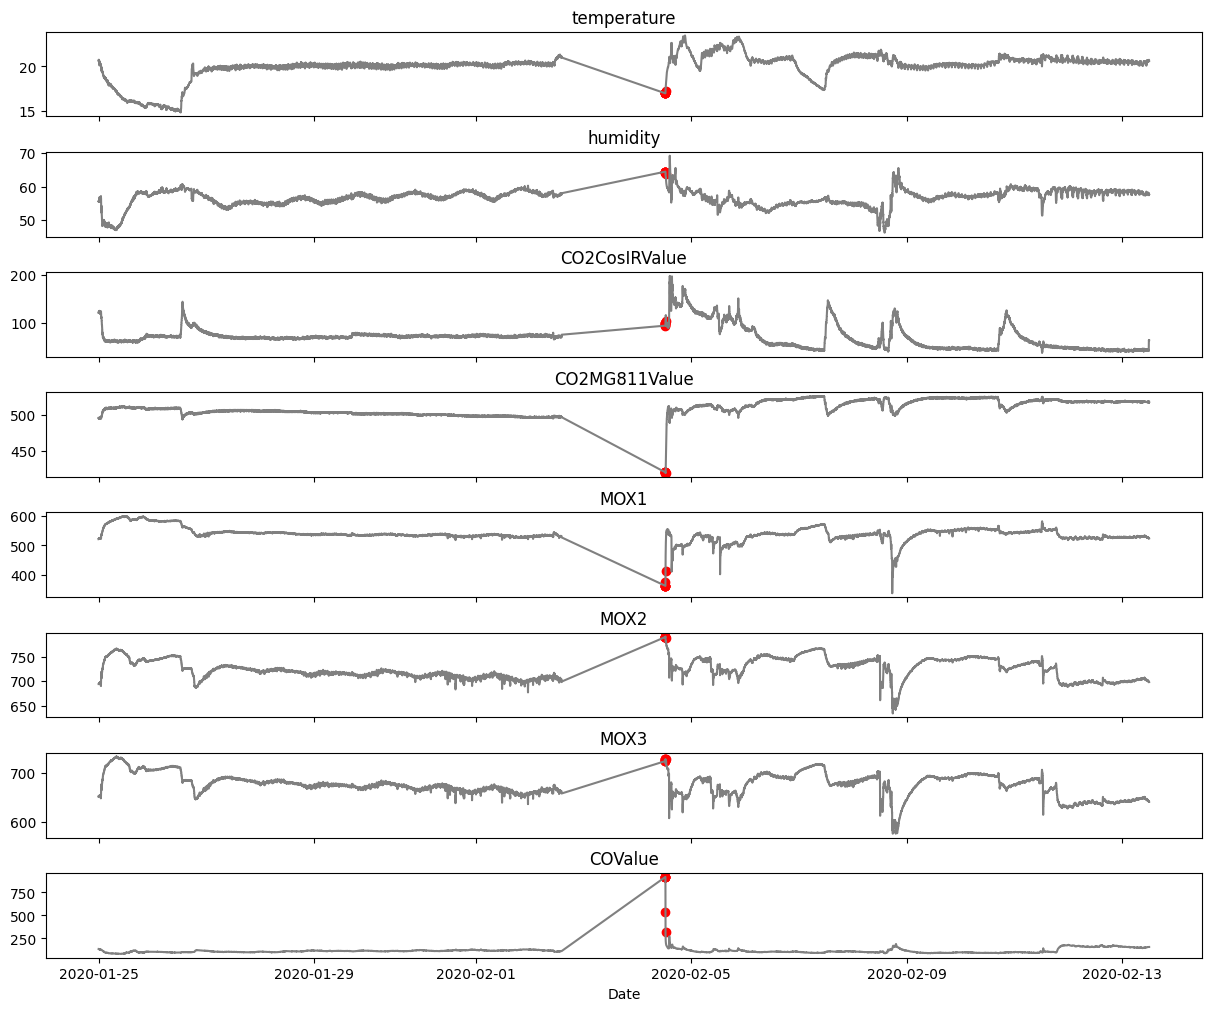

In [21]:
# убедимся, что десериализованная модель работает так же
pred = model.predict(X)
df["anomaly"] = pred
show_plots(df, datetime_col, columns, 'anomaly')

## Minimum Covariance Determinant (MCD)

### Train

In [22]:
# поскольку это эталонные данные считаем, что аномалий в них нет
# однако с 0-ем алгоритмы не работают. Поэтому поставим маленькое значение.
outliers_fraction = 0.0001

model = MCD(contamination=outliers_fraction, random_state=random_state)

In [23]:
model.fit(X)

MCD(assume_centered=False, contamination=0.0001,
  random_state=RandomState(MT19937) at 0x7F0310C54A40,
  store_precision=True, support_fraction=None)

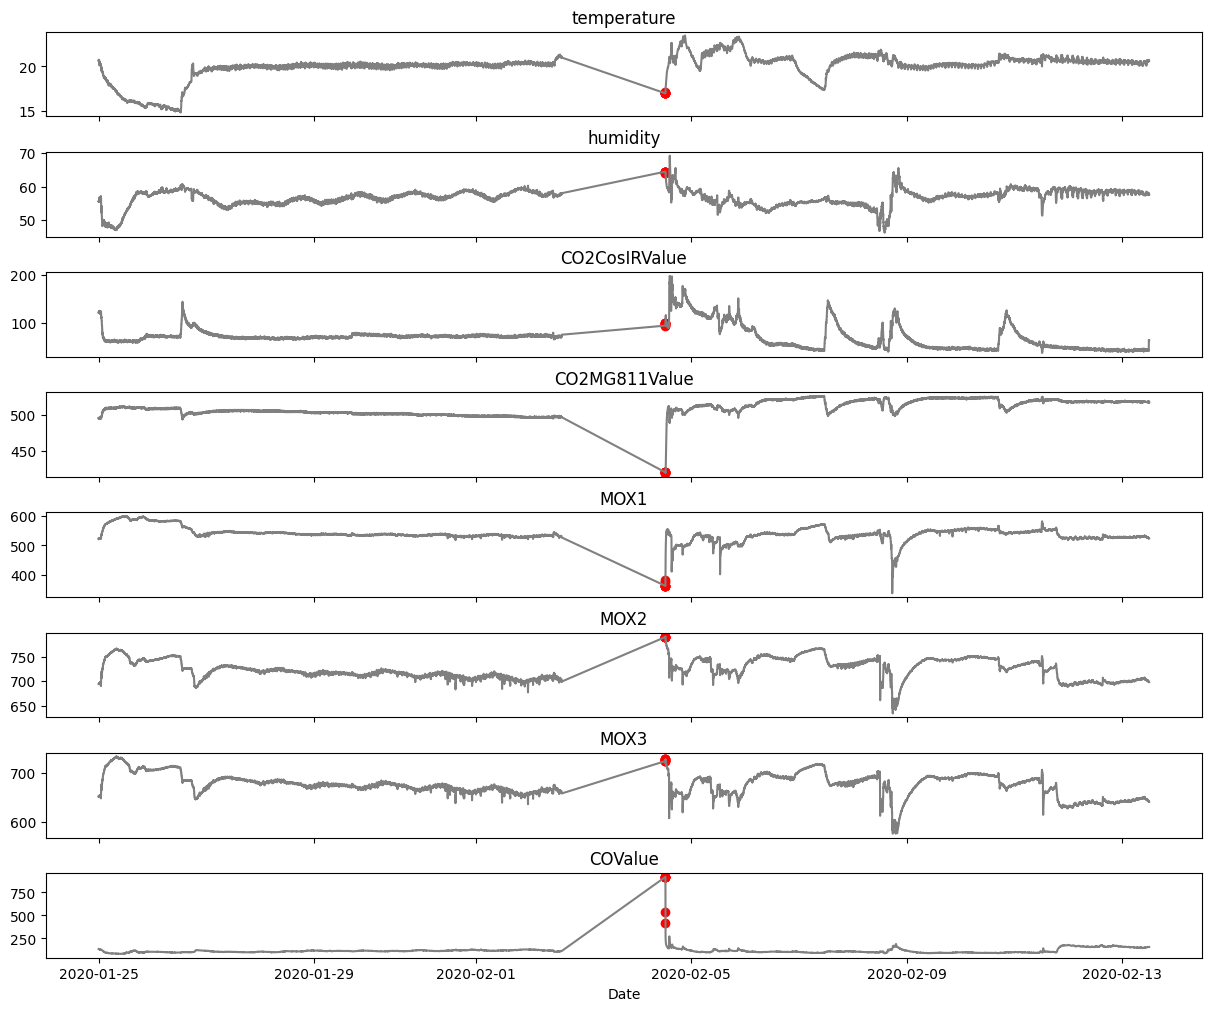

In [24]:
pred = model.predict(X)
df["anomaly"] = pred
show_plots(df, datetime_col, columns, 'anomaly')

### Predict

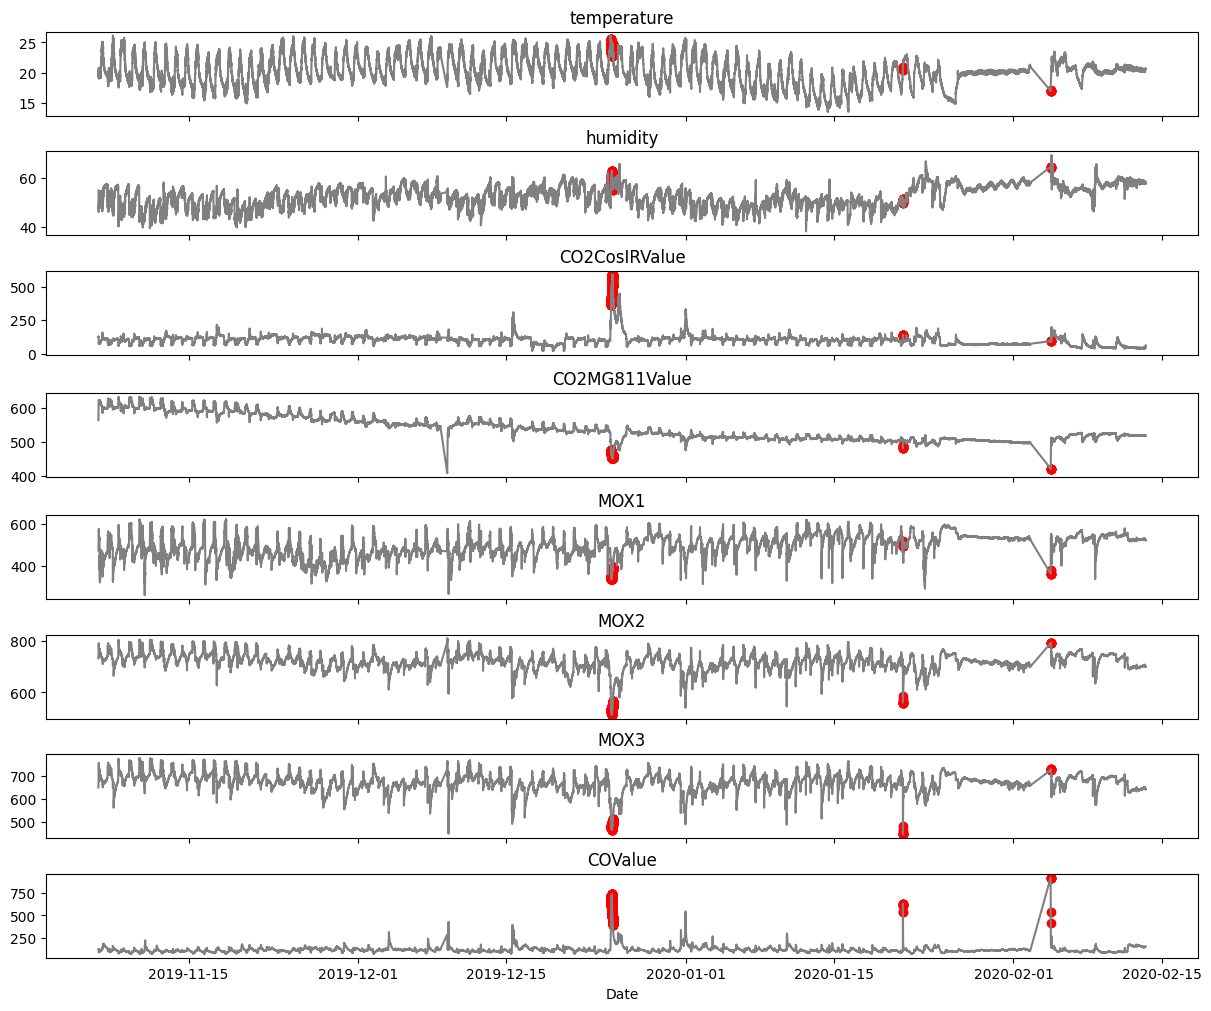

In [25]:
pred = model.predict(X_test)

df_test["anomaly"] = pred
show_plots(df_test, datetime_col, columns, "anomaly")

### Сохраняем модель

Согласно офф. документации ([ссылка](https://pyod.readthedocs.io/en/latest/model_persistence.html))

In [26]:
model_filename = "MCD_model.joblib"
model_path = os.path.join(models_dir, model_filename)
dump(model, model_path)

['models/MCD_model.joblib']

### Оценим размер сериализованной модели

In [27]:
model_size = os.path.getsize(model_path) / 1024**2
print(f"{model_size:.3} Мб")

1.88 Мб


### Загрузим модель

In [28]:
# load the model
model = load(model_path)

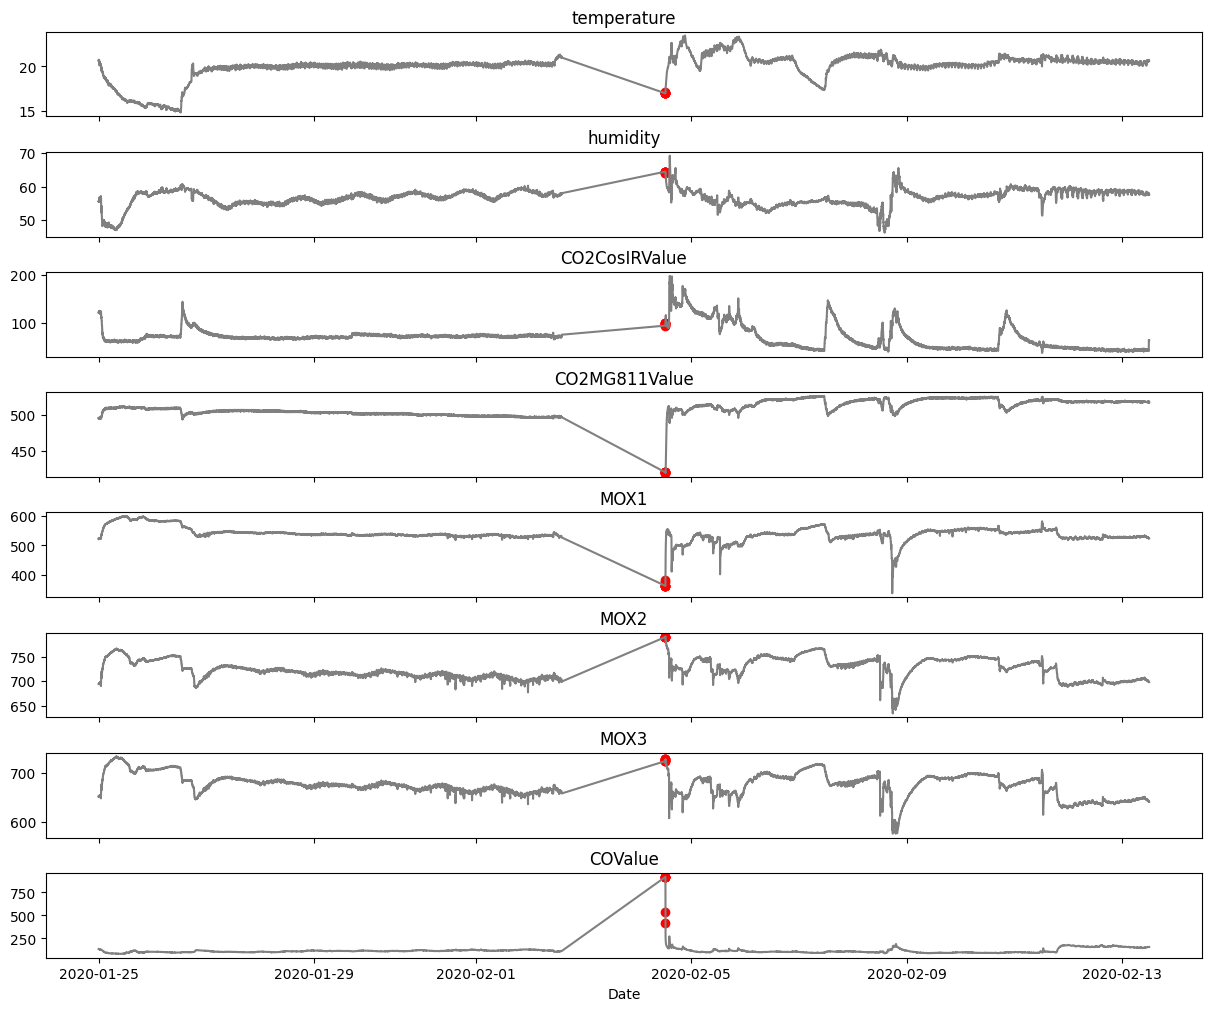

In [29]:
# убедимся, что десериализованная модель работает так же
pred = model.predict(X)
df["anomaly"] = pred
show_plots(df, datetime_col, columns, 'anomaly')

## Locally Selective Combination of Parallel Outlier Ensembles (LSCP)

### Train

In [36]:
# поскольку это эталонные данные считаем, что аномалий в них нет
# однако с 0-ем алгоритмы не работают. Поэтому поставим маленькое значение.
outliers_fraction = 0.0001

detector_list = [
    PCA(contamination=outliers_fraction, random_state=random_state),
    HBOS(contamination=outliers_fraction),
    LOF(contamination=outliers_fraction),
    IForest(contamination=outliers_fraction, random_state=random_state),
    MCD(contamination=outliers_fraction, random_state=random_state),
]

lscp_detector = LSCP(
    detector_list, contamination=outliers_fraction, random_state=random_state
)

In [37]:
model.fit(X)

MCD(assume_centered=False, contamination=0.0001,
  random_state=RandomState(MT19937) at 0x7F0316847540,
  store_precision=True, support_fraction=None)

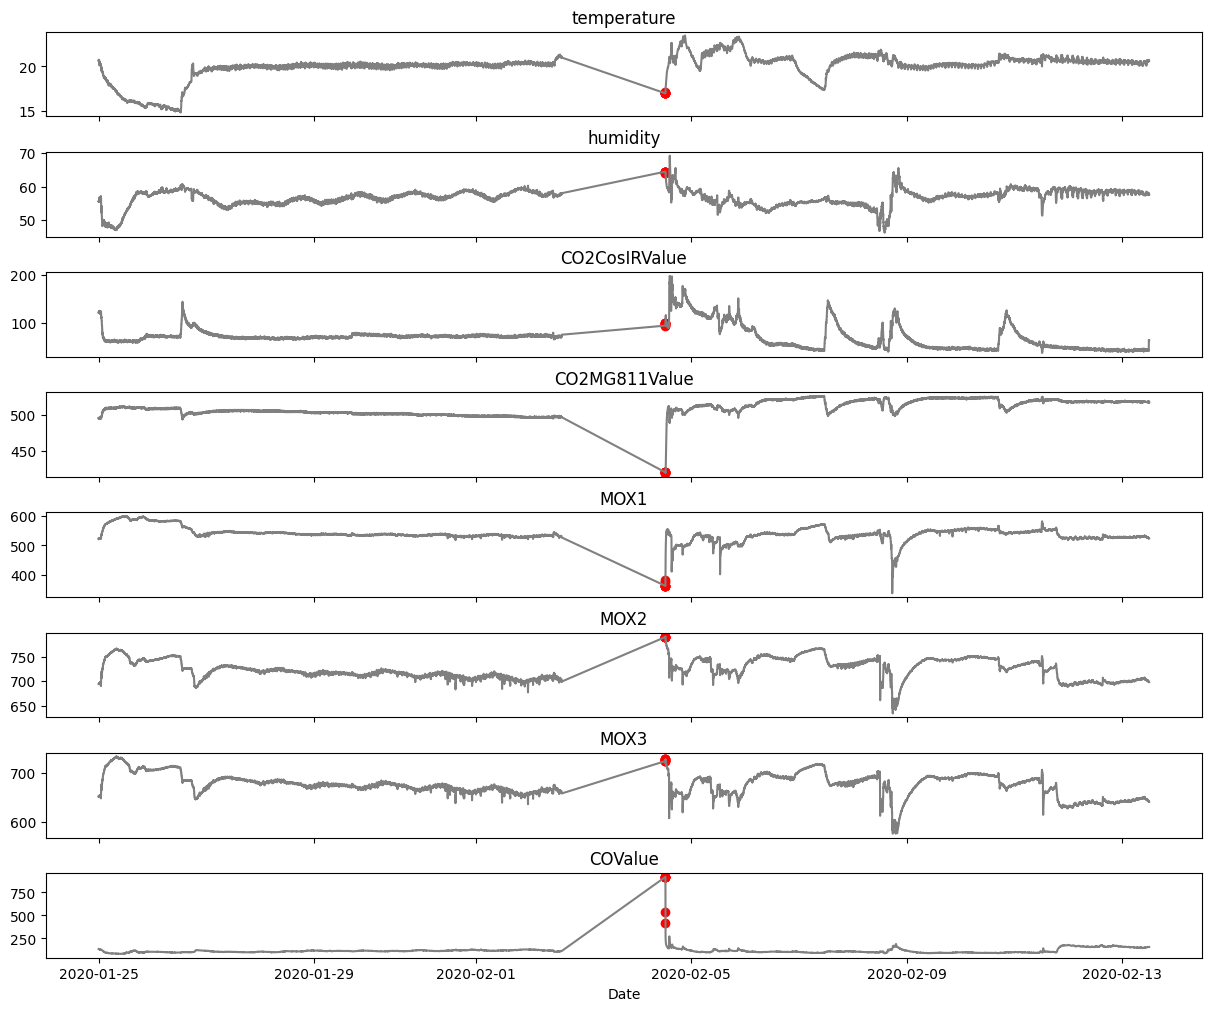

In [38]:
pred = model.predict(X)
df["anomaly"] = pred
show_plots(df, datetime_col, columns, 'anomaly')

### Predict

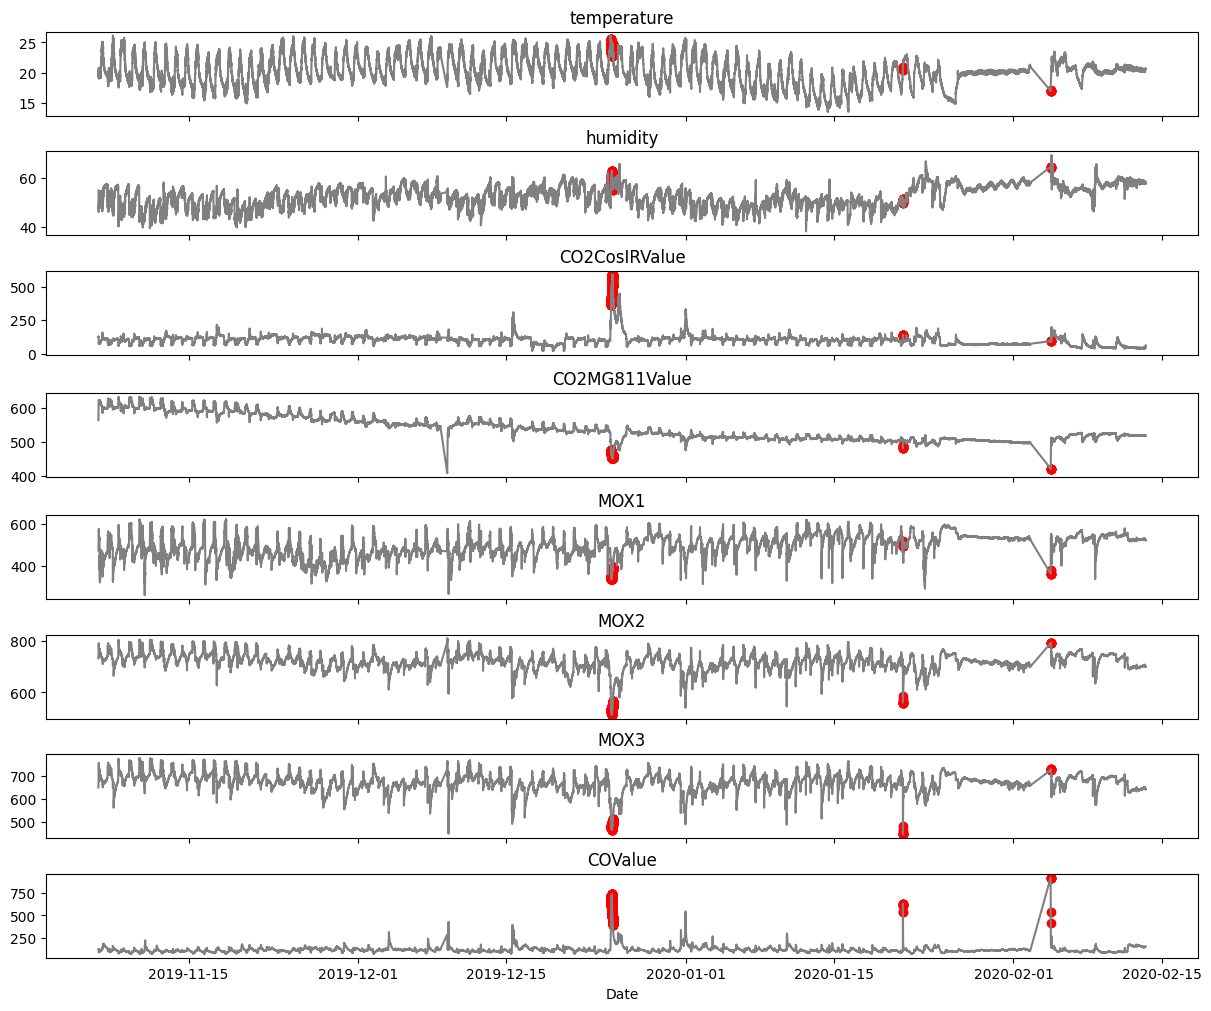

In [39]:
pred = model.predict(X_test)

df_test["anomaly"] = pred
show_plots(df_test, datetime_col, columns, "anomaly")

### Сохраняем модель
Согласно офф. документации ([ссылка](https://pyod.readthedocs.io/en/latest/model_persistence.html))


In [40]:
model_filename = "LSCP_model.joblib"
model_path = os.path.join(models_dir, model_filename)
dump(model, model_path)

['models/LSCP_model.joblib']

### Оценим размер сериализованной модели

In [41]:
model_size = os.path.getsize(model_path) / 1024**2
print(f"{model_size:.3} Мб")

1.88 Мб


### Загрузим модель

In [42]:
# load the model
model = load(model_path)

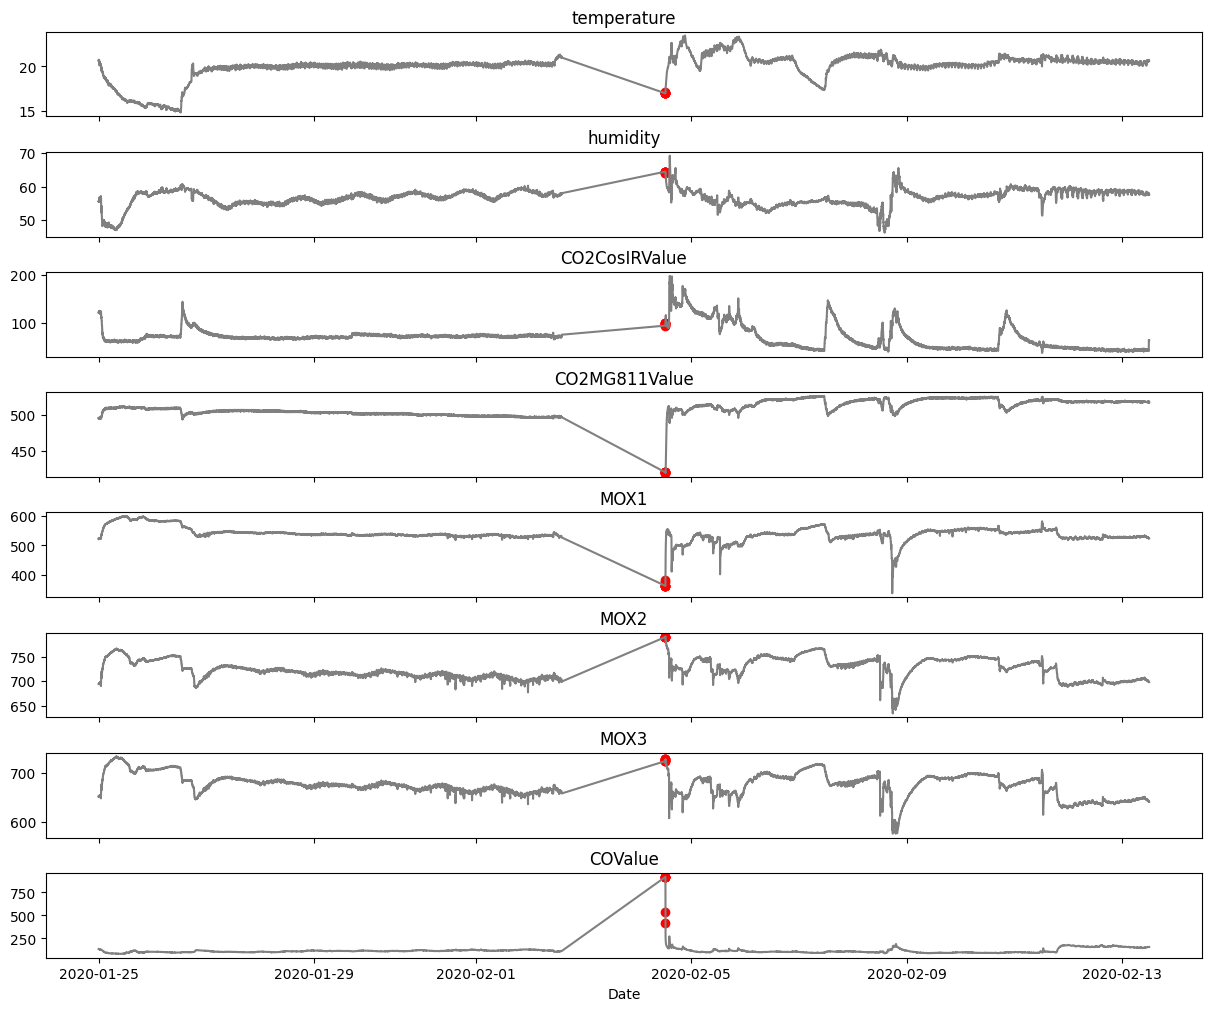

In [43]:
# убедимся, что десериализованная модель работает так же
pred = model.predict(X)
df["anomaly"] = pred
show_plots(df, datetime_col, columns, 'anomaly')

# Подведение итогов

Были обучены две простые модели для детекции аномалий в многомерных временных рядах:

* Histogram-based Outlier Detection (HBOS)
* Minimum Covariance Determinant (MCD)
* Locally Selective Combination of Parallel Outlier Ensembles (LSCP) как ансамбль из 
    1. PCA
    2. HBOS
    3. LOF
    4. IForest
    5. MCD

который правда по итогу получился моделью MCD =)

Использовать нейросети-автокодировщики нам было нельзя, а из простых методов побеждает MCD.

Но нужна модель для взимания повышенного билинга, - LSPD как ансамбль моделей годится на эту роль )

Все модели успешно сериализуются и десериализуются.